In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

In [3]:
import nltk
from nltk.corpus import stopwords

from konlpy.tag import Okt  
okt=Okt()

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image # 만약 "No module named 'PIL'" 에러가 발생하면 [ pip install Pillow==5.4.1 ] 로 라이브러리를 설치해줍니다.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#!pip install nltk==3.4
#nltk.download()

# 멜론 가사 크롤링

In [2]:
def melon_age_search(age):
    
    titles = []
    artists = []
    genres = []
    lyrics = []
    
    cnt = 0
    
    age_url = 'https://www.melon.com/chart/age/list.htm'
    params = {
        'idx': 2,
        'chartType': 'YE',
        'chartGenre': 'KPOP',
        'chartDate': age,
        'moved': 'Y',
    }
    
    headers = {
        'Referer': 'https://www.melon.com/index.htm',
        'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 \
                       (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36')
    }
    
    html = requests.get(age_url, params = params, headers = headers)
    print(html)
    soup = BeautifulSoup(html.text, 'html.parser')
    
    
    
    for tag in soup.select('.t_left'):
        try:
            #제목
            playsong = tag.select_one('.rank01 a[href*=playSong]')
            title = playsong['title']
            js = playsong['href']
            titles.append(title)
            
            #아티스트
            artist_detail = tag.select_one('.rank02 .checkEllipsis a')
            artist = artist_detail.text
            artists.append(artist)
            
            
            #앨범명
#             album_detail = tag.select_one('.rank03 a')
#             album = album_detail.text
            
                  
        except:
            continue
    
        # JavaScript 부분에서 songIds 추출 (정규표현식 사용)
        # 숫자 부분을 ()로 묶어 그룹화, ')'기호는 이스케이프 처리
        matched = re.search(r",'(\d+)'\);", js)
        if matched:
            song_id = matched.group(1)
            song_url = 'https://www.melon.com/song/detail.htm?songId=' + song_id
        
        #print(title, js, album, song_url)
        
        html = requests.get(song_url, headers = headers)
        soup = BeautifulSoup(html.text, 'html.parser')
        
        #장르 
        genre = soup.find('dl',{'class':'list'}).get_text()
        genre = genre.split('\n')[6]
        genres.append(genre)
       
    
        #가사
        tag = soup.find(id='d_video_summary')
        tag = str(tag)
        tag = tag.replace('<div class="lyric" id="d_video_summary">', '').\
            replace('<!-- height:auto; 로 변경시, 확장됨 -->', '').\
            replace('<br/>', '/').replace('</div>', '').strip()
        lyrics.append(tag)    
        
        ### 추출 건수 제어를 위해 if문에서 cnt 사용
        cnt += 1
        if cnt == 100:
            break
        ###
        
    info_dict = {'Year':age,
                 'Title':titles,
                 'Artist':artists,
                 'Genre': genres,
                 'Lyric':lyrics}
    df_song = pd.DataFrame(info_dict)
    return df_song
    
 


  

In [234]:
# melon_age_search(2020)

In [235]:
#melon_age_search(2020).to_csv("2020.csv", mode='w', encoding='euc-kr')

In [236]:
#melon_age_search(2019).to_csv("2019.csv", mode='w', encoding='euc-kr')

In [ ]:
#melon_age_search(2018).to_csv("2018.csv", mode='w', encoding='euc-kr')

# 성별/ 장르별 빈도수

In [6]:
def Word_Count(genre_name):
    
    df_m = pd.read_csv('man_lyrics.csv')
    df_w = pd.read_csv('woman_lyrics.csv')
    
    if genre_name == 'm_all':
        m = df_m
    elif genre_name == 'w_all':
        m = df_w
    elif genre_name =='m_hiphop':
        m = df_m[df_m['Genre'] == '랩/힙합']
    elif genre_name == 'm_dance':
        m = df_m[df_m['Genre'] == '댄스']
    elif genre_name == 'm_balad':
        m = df_m[df_m['Genre'] == '발라드']     
    elif genre_name =='w_hiphop':
        m = df_w[df_w['Genre'] == '랩/힙합']
    elif genre_name == 'w_dance':
        m = df_w[df_w['Genre'] == '댄스']
    elif genre_name == 'w_balad':
        m = df_w[df_w['Genre'] == '발라드']
        
    m_lyrics = m['Lyric'].tolist() 

    for i in range(len(m_lyrics)):
        m_lyrics[i] = str(m_lyrics[i])
    #곡별로 okt 처리 
    okt = Okt()
    m_sample=[]
    for i in m_lyrics:
        m_sample.append(okt.pos(i))
    del_list = ['하다', '있다', '되다', '이다', '돼다', '않다', '그렇다', '아니다', '이렇다', '그렇다', '어떻다'] 
    add_list = [ '말', '눈', '밤', '속', '맘', '꿈', '위', '손', '별', '일', '곁', '끝', '앞', '돈', '길','빛', '봄', '척', '꼭', '술', '꽃', '애', '향', '삶', '차', '숨', '새', '잠', '불', '북', '남', '힘', '배', '달', '피', '옷', '몸', '춤', '발', '방', '빵', '개', '형', '답', '랩', '멋', '욕', '땀', '법', '꽉', '점', '귀', '밑','잎', '덕', '틈', '문', '감', '물', '탓', '뇌', '목', '키' ]
    stop_words = stopwords.words('english')  #영어 불용어 처리  

    m_word_cleaned = []
    for i in range(len(m_sample)):
        m_word_cleaned.append([])

    for i in range(len(m_sample)):
        for j in range(len(m_sample[i])):
            if m_sample[i][j][0] not in m_word_cleaned[i]:
                if not m_sample[i][j][1] in ["Josa", "Eomi", "Punctuation", "Foreign"]: # Foreign == ", " 와 같이 제외되어야할 항목들
                    if (m_sample[i][j][0] not in del_list) & (m_sample[i][j][0] not in stop_words) & (len(m_sample[i][j][0]) != 1): # 원치 않는 단어들을 제외 & 영어 불용어 
                        m_word_cleaned[i].append(m_sample[i][j][0].lower())  #소문자처리
                    elif len(m_sample[i][j][0]) == 1:
                        if m_sample[i][j][0] in add_list:
                            m_word_cleaned[i].append(m_sample[i][j][0].lower())
    #중복 값 제거 코드
    m_set_word = []
    for i in range(len(m_word_cleaned)):
        m_set_word.append(list(set(m_word_cleaned[i])))

    #한줄짜리 문장으로 만들기 (빈도수 세기 위한)
    m_join_word = []
    for i in m_set_word:
        m_join_word += i
        
    #빈도수 세기
    word_dic_m = {}

    for word in m_join_word:
        if word not in word_dic_m:
            word_dic_m[word] = 1 # changed from "0" to "1"
        else:
            word_dic_m[word] += 1
    return word_dic_m

    #     m_word_dic = sorted(word_dic_m.items(), key=lambda x:x[1], reverse=True)
#     print(m_word_dic)

In [40]:
word_dic_m = Word_Count('m_all')
word_dic = Word_Count('w_all')

## 성별 워드클라우드

In [41]:
word_cloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf", # font_path="C:/Windows/Fonts/NanumSquareB.ttf"
                       width=2000, height=1000, # 이 부분을 수정하시면 실제 워드클라우드의 크기가 바뀝니다 (해상도가 바뀝니다)
                       # prefer_horizontal= 1.0, # 이 부분의 주석을 해제하시면 단어들이 가로로만 그려지게 됩니다. (0~1)
                       background_color='white')

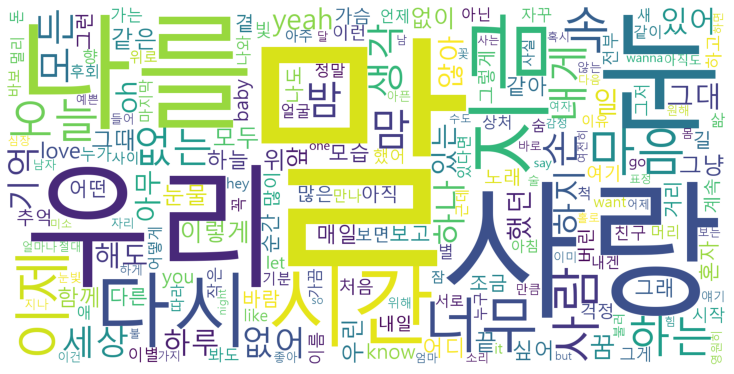

In [43]:
word_cloud.generate_from_frequencies(word_dic_m)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

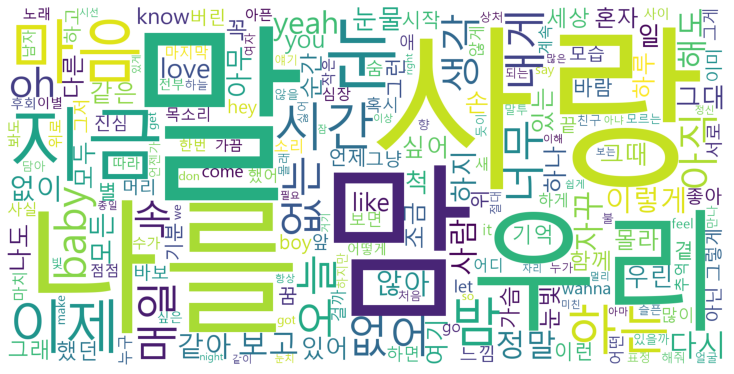

In [44]:
word_cloud.generate_from_frequencies(word_dic)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [105]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # NanumGothic.otf
matplotlib.rc('font', family=font_name)

# 장르별 가사 차이 

In [12]:
import operator

m_hiphop = sorted(Word_Count('m_hiphop').items(), key=lambda x:x[1], reverse=True)
w_hiphop = sorted(Word_Count('w_hiphop').items(), key=lambda x:x[1], reverse=True)
m_balad = sorted(Word_Count('m_balad').items(), key=lambda x:x[1], reverse=True)
w_balad = sorted(Word_Count('w_balad').items(), key=lambda x:x[1], reverse=True)
m_dance = sorted(Word_Count('m_dance').items(), key=lambda x:x[1], reverse=True)
w_dance = sorted(Word_Count('w_dance').items(), key=lambda x:x[1], reverse=True)

In [13]:
Word_Count('m_hiphop')

{'있잖아': 3,
 '그래도': 8,
 '새로운': 8,
 '발걸음': 4,
 '나면': 3,
 '하루': 13,
 '되리': 1,
 '이유': 8,
 '일': 17,
 '빼곤': 2,
 '말': 42,
 '하네': 3,
 '잊어': 2,
 'wrong': 1,
 '모든': 24,
 '미끄러져': 1,
 '분침': 1,
 '그래': 17,
 '행복하기를': 1,
 '누워': 2,
 '얄밉네': 1,
 '끝나잖아': 1,
 '모아': 4,
 'is': 3,
 '지나간': 3,
 'and': 7,
 '노래': 17,
 '해도': 20,
 '달라질까': 1,
 '없어': 29,
 'around': 1,
 '떨어지질': 1,
 '아닐': 3,
 '그런': 12,
 '내려앉은': 1,
 '없어져': 1,
 'fault': 1,
 '오늘': 28,
 '치열해': 1,
 '보이는': 4,
 '눈': 43,
 '거리': 13,
 '쉬자': 1,
 '바쁘고': 1,
 'gonna': 5,
 '내게': 24,
 '메아리': 1,
 '어지러운': 1,
 '침대': 3,
 '과속방지턱': 1,
 '시곌': 1,
 '숨': 9,
 'happy': 3,
 '기를': 2,
 '아주': 8,
 '덜컥': 2,
 '12시': 1,
 '도대체': 4,
 'zero': 2,
 '가사': 9,
 '쉬운': 2,
 '참고': 1,
 '구겨지고': 1,
 '초침': 2,
 '생각': 22,
 '같은데': 1,
 '내일': 15,
 '벌써': 6,
 '잠깐': 6,
 '지어져': 1,
 '하나': 17,
 '조금씩': 2,
 '해봐': 3,
 '새': 11,
 '쉽지': 2,
 'for': 2,
 '밤': 20,
 '시작': 9,
 '없는': 24,
 '맘': 11,
 '답': 9,
 '자꾸': 8,
 '없이': 18,
 '몸': 14,
 '무겁고': 1,
 '겹칠': 1,
 '않아': 25,
 '같은': 12,
 '곳곳': 2,
 '혼잣말': 1,
 '토닥여': 1,
 '처음처럼': 2,
 '슬픈

In [14]:
len(m_hiphop)

6354

In [17]:
df = pd.DataFrame(data = list(zip(m_hiphop, w_hiphop, m_balad, w_balad, m_dance, w_dance)), columns = ['남자힙합','여자힙합','남자발라드','여자발라드','남자댄스','여자댄스'])
df.index = df.index+1
df.head(30)

,남자힙합,여자힙합,남자발라드,여자발라드,남자댄스,여자댄스
1,"(눈, 43)","(like, 7)","(사랑, 84)","(사랑, 41)","(말, 22)","(말, 48)"
2,"(말, 42)","(got, 6)","(말, 72)","(우리, 28)","(yeah, 20)","(맘, 42)"
3,"(우리, 35)","(지금, 6)","(우리, 52)","(말, 27)","(나를, 18)","(baby, 36)"
4,"(이제, 33)","(말, 5)","(다시, 44)","(나를, 21)","(oh, 17)","(지금, 33)"
5,"(하는, 31)","(위, 5)","(나를, 39)","(맘, 20)","(눈, 16)","(나를, 33)"
6,"(손, 30)","(girl, 4)","(맘, 39)","(그때, 19)","(오늘, 14)","(눈, 30)"
7,"(없어, 29)","(내게, 4)","(눈, 36)","(아직, 17)","(이제, 14)","(oh, 30)"
8,"(속, 29)","(이제, 4)","(그대, 36)","(마음, 17)","(지금, 13)","(없어, 28)"
9,"(지금, 29)","(나를, 4)","(기억, 36)","(다시, 17)","(하지, 13)","(우리, 28)"
10,"(오늘, 28)","(눈, 4)","(시간, 35)","(했던, 17)","(맘, 13)","(사랑, 27)"


### 중복되는 단어 제거

In [48]:
#6가지 장르에서 모두 등장하는 단어를 제거 
word_del = set(Word_Count('m_hiphop')) & set(Word_Count('w_hiphop')) & set(Word_Count('m_balad')) & set(Word_Count('w_balad')) & set(Word_Count('m_dance')) & set(Word_Count('w_dance'))
word_del = list(word_del)
word_del

['ooh',
 '주고',
 '있는',
 '척',
 '힘',
 '애',
 '연습',
 '점점',
 '하게',
 '일',
 '꼭',
 '몰라',
 '신경',
 '말',
 '아무리',
 '아닌',
 '곁',
 '있게',
 '걸어',
 '추억',
 '다음',
 '모든',
 '이런',
 '아무',
 '그래',
 '매일',
 '남',
 '어떤',
 '그렇게',
 '속',
 '길',
 '많은',
 '애써',
 '모르게',
 '결국',
 '수가',
 '나와',
 '가슴',
 '한번',
 '노래',
 '해도',
 '사람',
 '없어',
 '너무',
 '의미',
 '아파',
 '이미',
 'oh',
 '감정',
 '머리',
 '빛',
 '여자',
 '느낌',
 '오늘',
 '와서',
 '가장',
 '소리',
 '같이',
 '마음',
 '눈',
 '거리',
 '감아',
 '불',
 '다시',
 '미련',
 '우리',
 '만난',
 '지금',
 '내게',
 '바람',
 '시간',
 '있던',
 '숨',
 '향',
 'you',
 '우린',
 '전화',
 '문제',
 '아주',
 'love',
 '했던',
 '좋아',
 '이렇게',
 '앞',
 '사랑',
 '생각',
 'now',
 '하나',
 '오직',
 '하지',
 '새',
 '시작',
 '밤',
 '아마',
 '옷',
 '없는',
 '하는',
 '맘',
 '얼굴',
 '답',
 '전부',
 'know',
 '미친',
 '싶어',
 '이제',
 '없이',
 '여기',
 '아직',
 '차라리',
 'so',
 '않아',
 '같은',
 '마치',
 '만들어',
 '위',
 '남자',
 '나도',
 '별',
 '어깨',
 '물',
 '이대로',
 'yeah',
 '눈빛',
 '같아',
 '멀리',
 '따라',
 '세상',
 '그저',
 '고개',
 '계속',
 '이건',
 '기억',
 '모두',
 '됐어',
 '끝',
 '그만',
 '손',
 '어디',
 '하고',
 '이별',
 '보여',
 '눈물',
 '보고',
 'baby',


In [19]:
m_hiphop_cleaned = []
for i in range(len(m_hiphop)):
    if m_hiphop[i][0] not in word_del:
        m_hiphop_cleaned.append(m_hiphop[i])

In [20]:
w_hiphop_cleaned = []
for i in range(len(w_hiphop)):
    if w_hiphop[i][0] not in word_del:
        w_hiphop_cleaned.append(w_hiphop[i])


In [21]:
m_balad_cleaned = []
for i in range(len(m_balad)):
    if m_balad[i][0] not in word_del:
        m_balad_cleaned.append(m_balad[i])


In [22]:
w_balad_cleaned = []
for i in range(len(w_balad)):
    if w_balad[i][0] not in word_del:
        w_balad_cleaned.append(w_balad[i])


In [23]:
m_dance_cleaned = []
for i in range(len(m_dance)):
    if m_dance[i][0] not in word_del:
        m_dance_cleaned.append(m_dance[i])


In [24]:
w_dance_cleaned = []
for i in range(len(w_dance)):
    if w_dance[i][0] not in word_del:
        w_dance_cleaned.append(w_dance[i])


In [49]:
df_cleaned = pd.DataFrame(data = list(zip(m_hiphop_cleaned, w_hiphop_cleaned, m_balad_cleaned, w_balad_cleaned, m_dance_cleaned, w_dance_cleaned)), columns = ['남자힙합','여자힙합','남자발라드','여자발라드','남자댄스','여자댄스'])
df_cleaned.index = df_cleaned.index+1
df_cleaned.head(30)

,남자힙합,여자힙합,남자발라드,여자발라드,남자댄스,여자댄스
1,"(그냥, 24)","(like, 7)","(그대, 36)","(그때, 19)","(let, 12)","(자꾸, 24)"
2,"(하늘, 21)","(got, 6)","(하루, 31)","(그대, 16)","(like, 10)","(like, 19)"
3,"(돈, 20)","(girl, 4)","(그때, 30)","(정말, 14)","(hey, 10)","(boy, 19)"
4,"(이름, 19)","(돈, 3)","(혼자, 25)","(혼자, 14)","(go, 9)","(조금, 17)"
5,"(꿈, 19)","(했지, 3)","(함께, 23)","(바보, 11)","(심장, 9)","(hey, 17)"
6,"(like, 16)","(원해, 3)","(꿈, 18)","(하루, 11)","(it, 7)","(꿈, 16)"
7,"(내일, 15)","(em, 3)","(모습, 18)","(그런, 10)","(순간, 7)","(순간, 16)"
8,"(삶, 15)","(come, 3)","(조금, 18)","(함께, 10)","(come, 7)","(wanna, 16)"
9,"(but, 15)","(make, 3)","(다른, 18)","(많이, 9)","(조금, 6)","(정말, 15)"
10,"(친구, 15)","(bad, 3)","(처음, 17)","(혹시, 9)","(하늘, 6)","(다른, 14)"


In [31]:
m_hiphop_dic = dict(m_hiphop_cleaned)
w_hiphop_dic = dict(w_hiphop_cleaned)
m_balad_dic = dict(m_balad_cleaned)
w_balad_dic = dict(w_balad_cleaned)
m_dance_dic = dict(m_dance_cleaned)
w_dance_dic = dict(w_dance_cleaned)

# 워드클라우드

### 남자 힙합

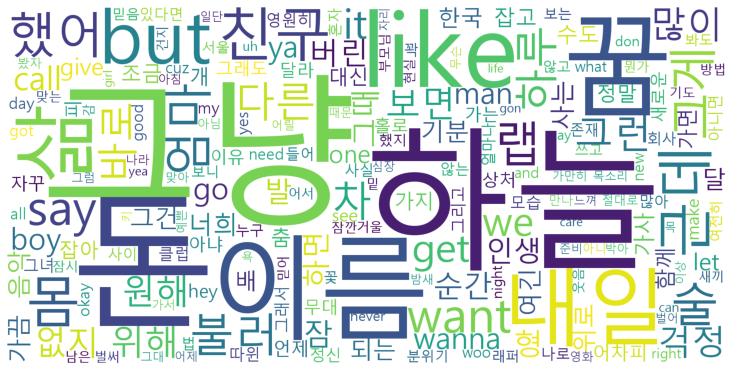

In [33]:
word_cloud.generate_from_frequencies(m_hiphop_dic)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 여자힙합

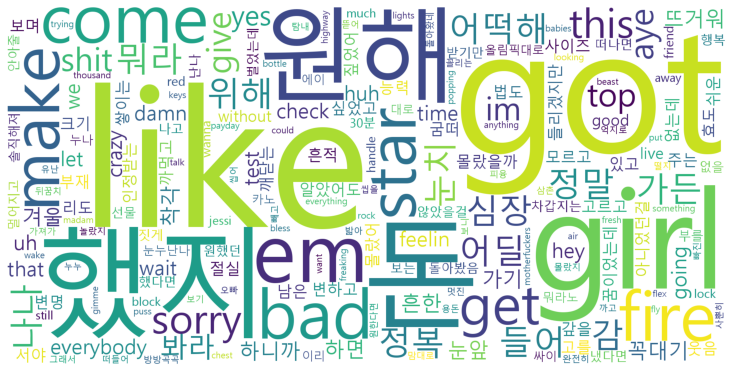

In [34]:
word_cloud.generate_from_frequencies(w_hiphop_dic)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 남자 발라드

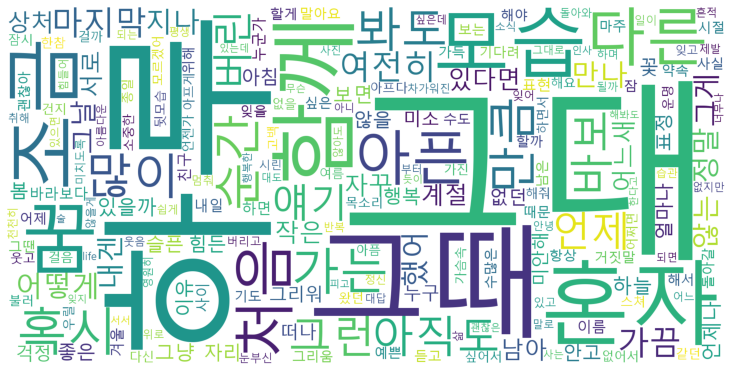

In [35]:
word_cloud.generate_from_frequencies(m_balad_dic)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 여자 발라드

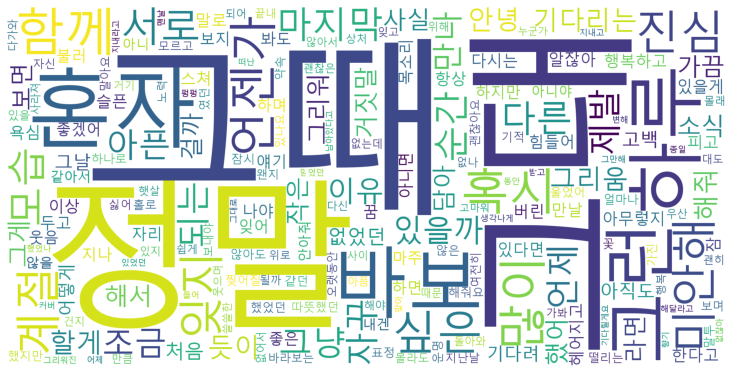

In [36]:
word_cloud.generate_from_frequencies(w_balad_dic)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 남자 댄스

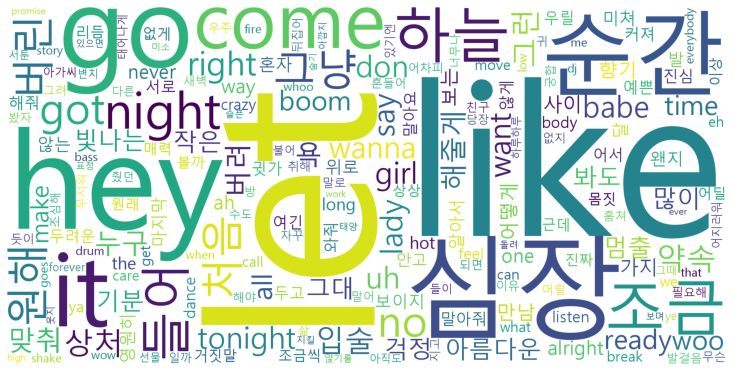

In [37]:
word_cloud.generate_from_frequencies(m_dance_dic)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 여자 댄스

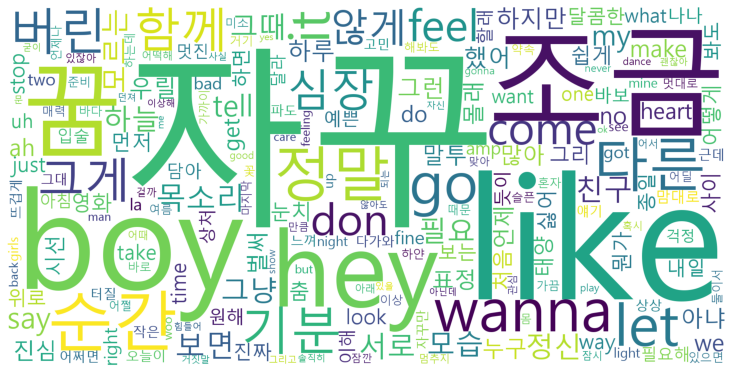

In [38]:
word_cloud.generate_from_frequencies(w_dance_dic)
plt.figure(figsize=(10,10)) # 이 부분을 수정하시면 화면에서 보여지는 워드클라우드의 크기가 바뀝니다 
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()